<a href="https://colab.research.google.com/github/lonen8188/AIStudy24/blob/master/%ED%8A%B8%EB%A6%AC%EC%99%80%EC%95%99%EC%83%81%EB%B8%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install xgboost
!pip install pycaret

In [1]:
# 앙상블 : 단어 그대로 여러 단순한 모델을 결합하여 정확한 모델을 만드는 방법
# 정형데이터 : 지금까지 학습한 수치자료가 있는 값
# 비정형데이터 : 데이터베이스나 엑셀로 표현하기 어려운 데이터
#       (텍스트데이터, 디카사진, mp3 등.) -> 신경망 알고리즘
# 랜덤 포레스트 : 결정 트리를 랜덤하게 만들어 결정트리(나무)숲 을 만듬
#       -> 최종 예측
# 1000개의 샘플이 들어 있는 가방에서 100개을 샘플을 뽑을때 1개를 뽑고
# 뽑앗던 1개를 다시 가방에 넣음
# 중복된 샘플을 뽑을 수 있음 -> 부트스트랩 샘플이라고 함
# 부트스트랩 : 데이터 세트에서 중복을 허용하여 데이터를 샘플링

In [2]:
# 분류 모델인 : RandomForestClassifier는
#   기본적으로 전체 특성 개수의 제곱근만큼 특성을 선택
# 즉 4개의 특성이 있다면 노드마다 2개를 랜덤하게 선택하여 사용
# 다만 회귀 모델인 RandomForestRegressor는 전체 특성을 사용

# 사이킷 런의 랜덤 포레스트는 기본적으로
# 100개의 결정 트리를 이런 방식으로 훈련한다.
# 그 다음 분류일 때는 각 트리의 클래스별 확률을 평균하여
# 가장 높은 확율을 가진 클래스를 예측으로 삼는다.
# 회귀일 때는 단순히 각 트리의 예측을 평균함.
# 분류 : 샘플을 몇개의 클래스 중 하나로 분류하는 문제
# 회귀 : 임의의 어떤 숫자를 예측하는 문제

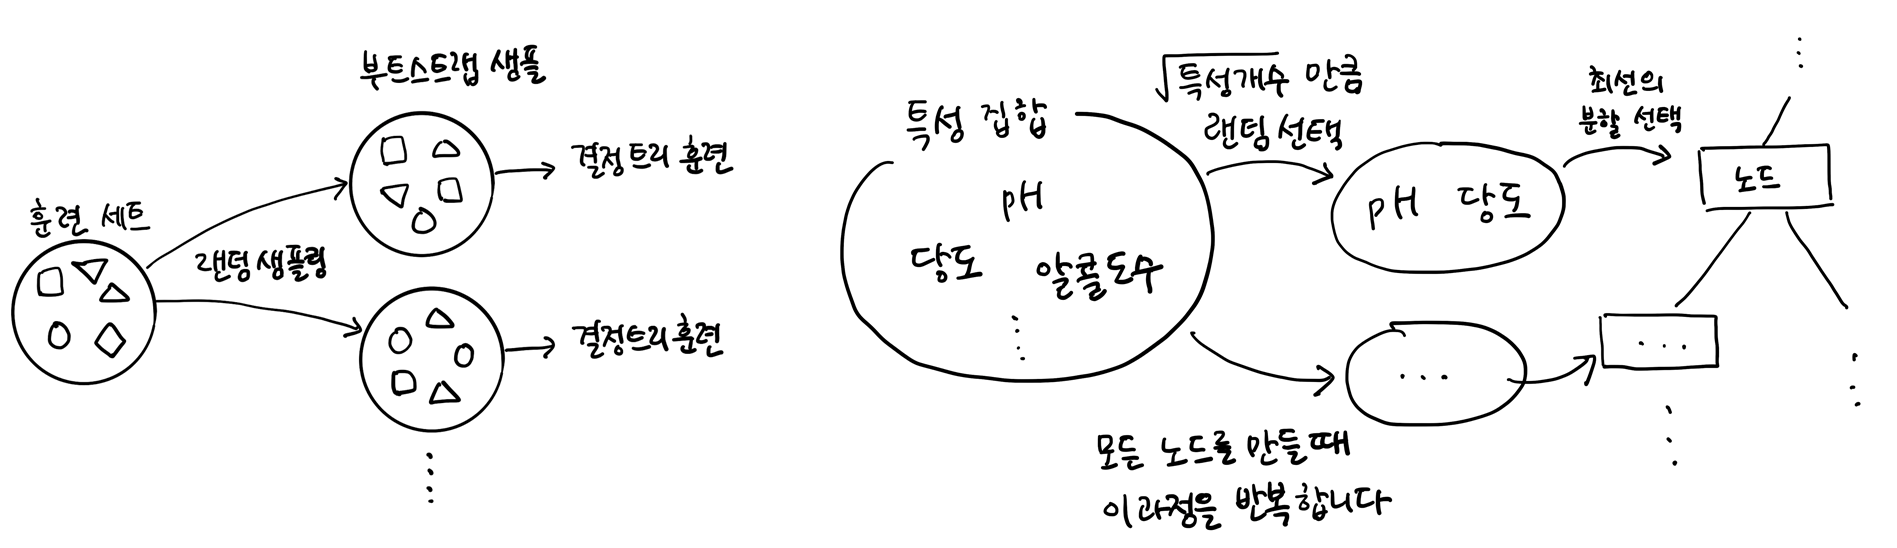

In [3]:
# 와인찾기 데이터
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

wine = pd.read_csv('https://bit.ly/wine_csv_data')

data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()
data

array([[ 9.4 ,  1.9 ,  3.51],
       [ 9.8 ,  2.6 ,  3.2 ],
       [ 9.8 ,  2.3 ,  3.26],
       ...,
       [ 9.4 ,  1.2 ,  2.99],
       [12.8 ,  1.1 ,  3.34],
       [11.8 ,  0.8 ,  3.26]])

In [4]:
target

array([0., 0., 0., ..., 1., 1., 1.])

In [5]:
# 훈련세트 80% 와 테스트세트 20% 로 나눔
train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42)
print(train_input.shape, test_input.shape )

(5197, 3) (1300, 3)


In [6]:
from sklearn.model_selection import cross_validate # 크로스 검증용
from sklearn.ensemble import RandomForestClassifier # 100개의 결정 트리 사용

rf = RandomForestClassifier(n_jobs=-1, random_state=42) # n_jobs=-1 모든 cpu 사용
scores = cross_validate(rf, train_input, train_target, return_train_score=True, n_jobs=-1)
# return_train_score=True 검증 점수와 훈련 세트에 대한 점수도 리턴

print(np.mean(scores['train_score']), np.mean(scores['test_score']))
# train_score 과대 적합 0.9973541965122431

0.9973541965122431 0.8905151032797809


In [7]:
# 랜덤 포레스트는 결정트리의 앙상블이기 때문에 결정트리가 제공하는 중요한 매개변수를 모두 제공함
# 결정 트리의 큰 장점중 하나인 특성 중요를 계산한다.
# 랜덤 포레스트의 특성 중요도는 각 결정 트리의 특성 중요도를 취합 한 것이다.
# 훈련 후에 중요도를 출력 해보자.
rf.fit(train_input, train_target) # 훈련 후 특성 중요도 출력
print(rf.feature_importances_)

[0.23167441 0.50039841 0.26792718]


In [8]:
# [0.23167441 0.50039841 0.26792718] 랜덤포레스트 현재 결과
# [0.12345626 0.86862934 0.0079144 ] LogisticRegression 이전 결과
# 알콜도수   , 당도      , pH 비교 해보자.
# 당도의 중요도가 감소하고, 알콜 도수와 pH 중요도가 상승함
# 이유는 랜덤포레스트가 특성 일부를 랜덤하게 선택하여 결정 트리를 훈련함(중복허용)
# 하나의 특성에 과도하게 집중하지 않고 좀 더 많은 특성이 훈련에 기여할 기회가됨(과대적합을 줄임)

# RandomForestClassifier기능중에 자체적으로 모델을 평가하는 점수를 얻을 수 있다.
# OOB(Out Of Bag)부트스트랩에 포함되지 않고 남은 샘플 -> 결정 트리 평가용(검증 세트로 활용)
# oob_score=True -> 랜덤 포레스트는 각 결정 트리의 OOB 점수를 평균하여 출력(oob_score_)
rf = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=42)

rf.fit(train_input, train_target)
print(rf.oob_score_)    # 교차 검증 점수와 비슷한 결과를 얻음
# OOB 점수를 사용하면 교차 검증을 대신할 수 있어 결과적으로 훈련 세트에 더 많은 샘플을 사용할수 있음

0.8934000384837406


In [9]:
# 엑스트라 트리 : 100개의 결정 트리 훈련 -> 부트스트랩 샘플을 사용하지 않음(전체 훈련세트 사용)
# 대신 노드를 분할할 때 가장 좋은 분할을 찾는 것이 아니라 무작위로 분할함!
# 엑스트라 트리의 결정 트리 splitter='random'
# 하나의 결정 트리에서 특성을 무작위로 분할한다면 성능이 낮아지겠지만
# 많은 트리를 앙상블 하기 때문에 과대 적합을 막고 검증세트의 점수를 높이는 효과가 있다.

from sklearn.ensemble import ExtraTreesClassifier # ExtraTreesClassifier 엑스트라 트리

et = ExtraTreesClassifier(n_jobs=-1, random_state=42)
scores = cross_validate(et, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))
# RandomForestClassifier와 결과가 비슷함. 대신 속도가 빠름

0.9974503966084433 0.8887848893166506


In [10]:
et.fit(train_input, train_target)
print(et.feature_importances_)

[0.20183568 0.52242907 0.27573525]


In [11]:
# [0.20183568 0.52242907 0.27573525] 엑스트라 트리 현재 결과
# [0.23167441 0.50039841 0.26792718] 랜덤포레스트 이전 결과
# [0.12345626 0.86862934 0.0079144 ] LogisticRegression 이전 결과
# 특성 중요도를 보면 결정 트리보다 당도에 대한 의존성이 작다.

In [12]:
# 그레이디언트 부스팅 Gradient Boosting(기울기)
# 깊이가 얕은 결정 트리를 사용하여 이전 트리의 오차를 보완하는 방식으로 앙상블
# 사이킷 런의 GradientBoostingClassifier는 기본적으로 깊이가 3인 결정 트리를 100개 사용
# 때문에 과대적합에 강하고 일반적인 높은 일반화 성능을 기대함

In [13]:
# Gradient는 경사 하강법을 사용하여 트리를 앙상블에 추가함.
# 분류 : 로지스틱 손실 함수, 회귀에서는 평균 제급 오차 함수를 사용
# 경사 하강법 손실 함수를 산으로 정의하고 가장 낮은 곳으로 찾아 내려오는 과정

# 가장 낮은 곳으로 내려오는 방법은 모델의 가중치와 절편을 조금씩 바꾸는 것
# 결정 트리를 계속 추가하면서 가장 낮은 곳을 찾아 이동, 손실함수의 낮은 곳으로 천천히 이동
from sklearn.ensemble import GradientBoostingClassifier
# GradientBoostingClassifier 그레디언트 부스팅

gb = GradientBoostingClassifier(random_state=42)
scores = cross_validate(gb, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))
# 과대 적합 해결 0.8881086892152563 0.8720430147331015

0.8881086892152563 0.8720430147331015


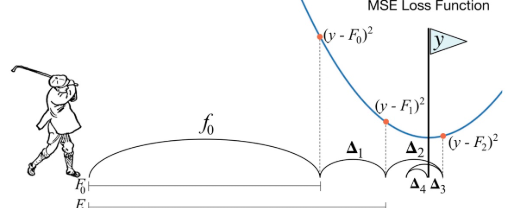

In [14]:
gb = GradientBoostingClassifier(n_estimators=500, learning_rate=0.2, random_state=42)
# n_estimators=500 결정트리개수를 500개로 늘림 기본값 100
# learning_rate=0.2 학습률 기본값 0.1
scores = cross_validate(gb, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score'])) # 교차 검증 점수 확인
# 94.64% 87.80% 훈련과, 검증 점수차이가 10%이상 나지 않으면 괜찮음(과대적합 아님)

0.9464595437171814 0.8780082549788999


In [15]:
gb.fit(train_input, train_target) # 훈련시작
print(gb.feature_importances_) # 당도에 의존도가 낮음
# 그레이디언트 부스팅이 랜덤포레스트보다 조금 더 높은 성능이 있다.
# 하지만 순서대로 트리를 추가하기 때문에 훈련속도가 좀 느리다.
# GradientBoostingClassifier에는 n_jobs=-1 매개값이 없다.(구형모델이라)

[0.15887763 0.6799705  0.16115187]


In [16]:
# [0.15887763 0.6799705  0.16115187] 그레이디언트 부스팅 현재 결과
# [0.20183568 0.52242907 0.27573525] 엑스트라 트리 이전 결과
# [0.23167441 0.50039841 0.26792718] 랜덤포레스트 이전 결과
# [0.12345626 0.86862934 0.0079144 ] LogisticRegression 이전 결과

In [17]:
# 히스토그램 기반 그레이언트 부스팅 Histogram Gradient : 그레이디언트 부스팅의 개선버전
# 입력 특성을 256 구간으로 나눔 -> 노드를 분할할 때 최적의 분할을 매우 빠르게 찾을 수 있다.
# 특히 256구간 중에서 하나를 떼어 놓고 누락된 값을 위해서 사용함
# HistGradientBoostingClassifier는 기본 매개변수에서 안정적인 성능을 얻을 수있다.
# HistGradientBoostingClassifier에는 트리의 개수를 지정하는데
# n_estimators 대신 max_iter를 사용함(성능 향상용)

# from sklearn.experimental import enable_hist_gradient_boosting 아직 개발중
from sklearn.ensemble import HistGradientBoostingClassifier # 분류용

hgb = HistGradientBoostingClassifier(random_state=42)
scores = cross_validate(hgb, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score'])) # 과대 적합 억제 성공!
# 93.21% , 88.01%

0.9321723946453317 0.8801241948619236


In [18]:
from sklearn.inspection import permutation_importance
# permutation_importance 특성 중요도 확인
# : 특성을 하나씩 랜덤하게 섞어서 모델의 성능이 변화되는지 관찰

# 히스토그램기반의 훈련을 진행 -> 훈련세트에서 특성 중요도를 계산해보자.
hgb.fit(train_input, train_target)

#n_repeats=10 랜덤하게 섞을 횟수 (기본 5)
result = permutation_importance(hgb, train_input, train_target, n_repeats=10,
                                random_state=42, n_jobs=-1)
print(result.importances_mean)
# 알콜도수   , 당도    , pH          비교 해보자.
# [0.08876275 0.23438522 0.08027708] 히스토그램 현재결과
# [0.15887763 0.6799705  0.16115187] 그레이디언트 부스팅 이전 결과
# [0.20183568 0.52242907 0.27573525] 엑스트라 트리 이전 결과
# [0.23167441 0.50039841 0.26792718] 랜덤포레스트 이전 결과
# [0.12345626 0.86862934 0.0079144 ] LogisticRegression 이전 결과

[0.08876275 0.23438522 0.08027708]


In [19]:
# 이번에는 테스트 세트에 결과를 확인 해보자.
result = permutation_importance(hgb, test_input, test_target, n_repeats=10,
                                random_state=42, n_jobs=-1)
print(result.importances_mean)
# 알콜도수   , 당도    , pH          비교 해보자.
# [0.05969231 0.20238462 0.049     ] 테스트 세트에서 특성 중요도
# [0.08876275 0.23438522 0.08027708] 히스토그램 현재결과
# [0.15887763 0.6799705  0.16115187] 그레이디언트 부스팅 이전 결과
# [0.20183568 0.52242907 0.27573525] 엑스트라 트리 이전 결과
# [0.23167441 0.50039841 0.26792718] 랜덤포레스트 이전 결과
# [0.12345626 0.86862934 0.0079144 ] LogisticRegression 이전 결과

[0.05969231 0.20238462 0.049     ]


Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 5, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main.py", line 11, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main_parser.py", line 10, in <module>
    from pip._internal.cli import cmdoptions
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/cmdoptions.py", line 24, in <module>
    from pip._internal.cli.parser import ConfigOptionParser
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1002, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 945, in _find_spec
  File "<frozen i

In [21]:
# HistGradientBoostingRegressor 히스토그램 기반 그레이디언트 부스팅의 회귀 버전
# 사이킷런 말고도 그레이디언트 부스팅 알고리즘을 구현한 라이브러리가 다수 존재
# XGBoost 대표적임 -> 크로스검증이 가능(cross_validate())
from xgboost import XGBClassifier
# tree_method='hist' 히스토그램 기반 그레이디언트 부스팅용
# 만약 안되면 파이썬에 설치가 안된것임
# !pip install xgboost
# !pip install pycaret -> 세션 다시 시작하고 위에서부터 다시 객체 생성함

xgb = XGBClassifier(tree_method='hist', random_state=42)
scores = cross_validate(xgb, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))
# 95.58% , 87.82% 와인 교차 검증 점수

0.9558403027491312 0.8782000074035686


In [22]:
# LGBMClassifier ms에서 만든 LightGBM^2
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(random_state=42)
scores = cross_validate(lgb, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))
# 93.58% , 88.01%

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


0.935828414851749 0.8801251203079884
